In [10]:
import matplotlib.pyplot as plt
import datetime
import os
import json
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)
import numpy as np
import warnings
from mainGCN import *
from typing import Dict, Tuple


In [11]:
def create_metrics():
    return {"overall": {"roc_auc": [], "accuracy": [],"f1": [], "precision": [], "recall": []},
            "licit": {"precision": [], "recall": [],"f1-score": []}, 
           "illicit":{"precision": [], "recall": [],"f1-score": []}}

def hyperparameter_loop(group_para, parameter, parameter_list, metrics):
    """
    Run a grid search for a hyperparameter
    Args: hyperparameter, hyperparameter list, classification metrics (empty dict)
    Returns: Classification metrics dictionary
    """ 
    warnings.filterwarnings('ignore')
    for i in range(len(parameter_list)):
        config[group_para][parameter] = parameter_list[i]
        
        data = load_dataset(root=config["data"]["data_root"])

        model = GCN(in_channels=data.num_features,
                    hidden_channels=config["model"]["hid_dim"],
                    num_layers=config["model"]["num_layers"],
                    out_channels=2,
                    dropout=config["model"]["dropout"],
                    )
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        train_loader = create_loader(
            data,
            batch_size=config["data"]["batch_size"],
            num_neighbors=config["model"]["num_neigh"],
            use_train_mask=True,
        )

        # dataset, input_nodes = load_dataset(mask="train",use_aggregated=config["data"]["use_aggregated"],use_temporal=config["data"]["use_temporal"])
        # train_loader = make_loader(data=dataset, loader_type='neighbor', batch_size=config["data"]["batch_size"], input_nodes=input_nodes)
        # # train_data = get_data_from_loader(loader)

        # mymodel = create_model(config=config["model"])

        model, training_metrics = train_model(
            model,
            train_loader,
            learning_rate=config["model"]["lr"],
            device=device,
            num_epochs=config["model"]["epoch"],
            output_directory=config["training"]["save_dir"],
            # timestamp=timestamp,
            loss_type=config["loss"]["loss_type"],
            gamma=config["loss"]["gamma"],
            beta=config["loss"]["beta"],
        )

        test_metrics = test_model(
            model,
            data,
            device,
            batch_size=config["data"]["batch_size"],
            num_neighbors=config["model"]["num_neigh"],
            output_directory=config["training"]["save_dir"],
            # threshold=config["threshold"],
            # timestamp=timestamp,
            loss_type=config["loss"]["loss_type"],
            gamma=config["loss"]["gamma"],
            beta=config["loss"]["beta"],
        )

        # trained_model = train_model(mymodel, train_loader)
    
        # dataset, input_nodes = load_dataset(mask="test",use_aggregated=config["data"]["use_aggregated"],
        # use_temporal=config["data"]["use_temporal"])
        # test_loader = make_loader(data=dataset, loader_type='neighbor', batch_size=config["data"]["batch_size"], input_nodes=input_nodes)    
        # test_data = get_data_from_loader(test_loader)

        # test_metrics = test_model(model=trained_model, data=test_data, output_directory=config["training"]["save_dir"])

        for key in list(test_metrics.keys())[0:-1]:
            metrics["overall"][key].append(test_metrics[key])
        output = test_metrics["classification_report"]
        for key in list(output["0"].keys())[0:-1]:
            metrics["licit"][key].append(output["0"][key])
            metrics["illicit"][key].append(output["1"][key])
        
    return metrics

def plot_metrics(metrics, para_list, parameter, x_log = False):
    """
    Plot the classification metrics
    Args:classification metrics
    Returns:None
    """ 

    size = (8,3)
    plt.figure(figsize= size)
    for key in list(metrics["overall"]):
        plt.plot(para_list, metrics["overall"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Total Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Overall Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= size)
    for key in list(metrics["licit"]):
        plt.plot(para_list, metrics["licit"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Licit Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Licit Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= size)
    for key in list(metrics["illicit"]):
        plt.plot(para_list, metrics["illicit"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Illicit Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Illicit Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()


### Base GCN

In [12]:
config = {
        "model": {
            "hid_dim": 64,
            "num_layers": 2,
            "dropout": 0.01,
            "weight_decay": 0.0,
            "contamination": 0.1,
            # "backbone": "gcn",
            "lr": 0.005,
            "epoch": 10,
            "batch_size": 2048,
            "num_neigh": [10, 10],
            "weight": 0.5,
            "verbose": 1,
        },
        "data": {
            "data_root": "data/elliptic",
            "use_aggregated": False,
            "use_temporal": False,
            "batch_size": 16000
        },
        "loss": {
            "loss_type": "focal", # focal or ce
            "gamma": 1.0,
            "beta": 0.9999,
        },
        "training": {
            "save_embeddings": False,
            "save_dir": "./saved_models",
        },
        "classifiers": ["rf", "mlp"],
    }



#### Number of Layers

In [13]:
metrics = create_metrics()
para_change = "num_layers"
para_list = [2, 3, 4]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)



Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:04<00:44,  4.95s/it]

Avg Batch Loss: 2.420e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:09<00:38,  4.78s/it]

Avg Batch Loss: 1.048e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:14<00:33,  4.81s/it]

Avg Batch Loss: 9.234e-02, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:19<00:28,  4.77s/it]

Avg Batch Loss: 9.260e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:23<00:23,  4.74s/it]

Avg Batch Loss: 9.131e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:28<00:18,  4.66s/it]

Avg Batch Loss: 8.616e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:33<00:14,  4.82s/it]

Avg Batch Loss: 7.946e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:38<00:09,  4.86s/it]

Avg Batch Loss: 7.333e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:43<00:04,  4.77s/it]

Avg Batch Loss: 6.843e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:47<00:00,  4.80s/it]

Avg Batch Loss: 6.592e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]



Test Metrics:
Accuracy: 0.668
F1: 0.232
Precision: 0.136
Recall: 0.794

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     16443
           1       0.14      0.79      0.23      1106

    accuracy                           0.67     17549
   macro avg       0.56      0.73      0.51     17549
weighted avg       0.93      0.67      0.75     17549

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.7269447119585342, 'accuracy': 0.6684711379565788, 'f1': 0.2318457882228677, 'precision': 0.1357452071737786, 'recall': 0.7938517179023508, 'classification_report': {'0': {'precision': 0.9794242396895587, 'recall': 0.6600377060147176, 'f1-score': 0.7886208399941869, 'support': 16443.0}, '1': {'precision': 0.1357452071737786, 'recall': 0.7938517179023508, 'f1-score': 0.2318457882228677, 'support': 1106.0}, 'accuracy': 0.6684711379565788, 'macro avg': {'precision': 0.5575847234316686, 'recall': 0.726944711

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:04<00:44,  4.90s/it]

Avg Batch Loss: 2.122e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:10<00:40,  5.08s/it]

Avg Batch Loss: 1.377e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:14<00:34,  4.97s/it]

Avg Batch Loss: 1.018e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:19<00:29,  4.97s/it]

Avg Batch Loss: 9.324e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:24<00:24,  4.81s/it]

Avg Batch Loss: 8.650e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:28<00:18,  4.71s/it]

Avg Batch Loss: 7.786e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:33<00:13,  4.64s/it]

Avg Batch Loss: 7.449e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:37<00:09,  4.58s/it]

Avg Batch Loss: 7.411e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:42<00:04,  4.64s/it]

Avg Batch Loss: 7.195e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:47<00:00,  4.71s/it]

Avg Batch Loss: 6.737e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]



Test Metrics:
Accuracy: 0.536
F1: 0.191
Precision: 0.107
Recall: 0.883

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.51      0.67     16549
           1       0.11      0.88      0.19      1098

    accuracy                           0.54     17647
   macro avg       0.55      0.70      0.43     17647
weighted avg       0.93      0.54      0.64     17647

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6979188645608487, 'accuracy': 0.5362951209837367, 'f1': 0.19148305503408755, 'precision': 0.10739221988252244, 'recall': 0.8825136612021858, 'classification_report': {'0': {'precision': 0.9850417439703154, 'recall': 0.5133240679195118, 'f1-score': 0.6749294879434314, 'support': 16549.0}, '1': {'precision': 0.10739221988252244, 'recall': 0.8825136612021858, 'f1-score': 0.19148305503408755, 'support': 1098.0}, 'accuracy': 0.5362951209837367, 'macro avg': {'precision': 0.5462169819264189, 'recall': 0.69791

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:04<00:40,  4.46s/it]

Avg Batch Loss: 2.459e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:09<00:37,  4.74s/it]

Avg Batch Loss: 1.020e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:14<00:34,  4.95s/it]

Avg Batch Loss: 9.934e-02, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:19<00:28,  4.79s/it]

Avg Batch Loss: 8.511e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:23<00:23,  4.72s/it]

Avg Batch Loss: 8.102e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:28<00:18,  4.73s/it]

Avg Batch Loss: 7.999e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:33<00:14,  4.83s/it]

Avg Batch Loss: 7.575e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:38<00:09,  4.74s/it]

Avg Batch Loss: 7.312e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:42<00:04,  4.67s/it]

Avg Batch Loss: 7.053e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:47<00:00,  4.72s/it]

Avg Batch Loss: 6.683e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


Test Metrics:
Accuracy: 0.505
F1: 0.184
Precision: 0.102
Recall: 0.890

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.48      0.64     16529
           1       0.10      0.89      0.18      1103

    accuracy                           0.50     17632
   macro avg       0.54      0.68      0.41     17632
weighted avg       0.93      0.50      0.62     17632

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.684758763780486, 'accuracy': 0.5049342105263158, 'f1': 0.1836715608341906, 'precision': 0.10239833159541188, 'recall': 0.8902991840435177, 'classification_report': {'0': {'precision': 0.9849539915443919, 'recall': 0.4792183435174542, 'f1-score': 0.6447438036709943, 'support': 16529.0}, '1': {'precision': 0.10239833159541188, 'recall': 0.8902991840435177, 'f1-score': 0.1836715608341906, 'support': 1103.0}, 'accuracy': 0.5049342105263158, 'macro avg': {'precision': 0.5436761615699018, 'recall': 0.68475876

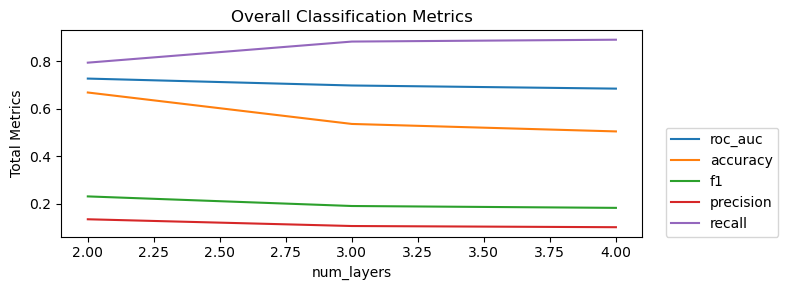

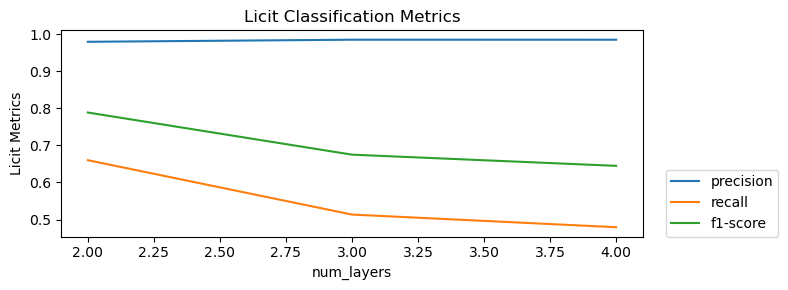

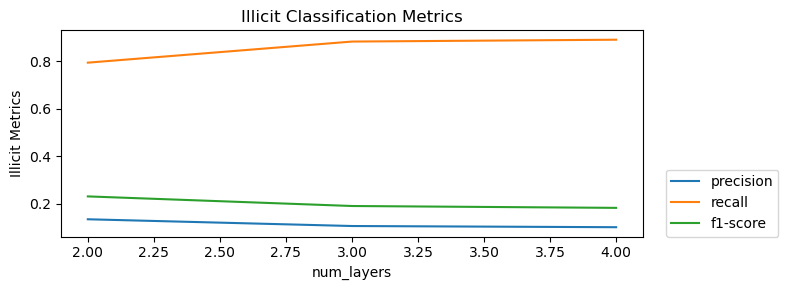

In [14]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Hidden Dimension


In [15]:
metrics = create_metrics()
para_change = "hid_dim"
para_list = [64, 128, 256, 512, 1024]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:04<00:42,  4.73s/it]

Avg Batch Loss: 2.563e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:09<00:38,  4.77s/it]

Avg Batch Loss: 1.953e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:14<00:33,  4.77s/it]

Avg Batch Loss: 1.346e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:18<00:28,  4.70s/it]

Avg Batch Loss: 1.033e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:23<00:23,  4.79s/it]

Avg Batch Loss: 9.615e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:28<00:18,  4.71s/it]

Avg Batch Loss: 9.588e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:33<00:14,  4.68s/it]

Avg Batch Loss: 8.795e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:37<00:09,  4.65s/it]

Avg Batch Loss: 8.339e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:42<00:04,  4.64s/it]

Avg Batch Loss: 7.976e-02, 
Epoch 10/10
Avg Batch Loss: 7.825e-02, 


Epochs: 100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]



Test Metrics:
Accuracy: 0.592
F1: 0.209
Precision: 0.119
Recall: 0.855

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.57      0.73     16507
           1       0.12      0.86      0.21      1111

    accuracy                           0.59     17618
   macro avg       0.55      0.71      0.47     17618
weighted avg       0.93      0.59      0.69     17618

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.7147845304915783, 'accuracy': 0.5921784538540129, 'f1': 0.20913593835993396, 'precision': 0.11913719588663155, 'recall': 0.8550855085508551, 'classification_report': {'0': {'precision': 0.9833056822895064, 'recall': 0.5744835524323014, 'f1-score': 0.7252495124469428, 'support': 16507.0}, '1': {'precision': 0.11913719588663155, 'recall': 0.8550855085508551, 'f1-score': 0.20913593835993396, 'support': 1111.0}, 'accuracy': 0.5921784538540129, 'macro avg': {'precision': 0.551221439088069, 'recall': 0.714784

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:06<00:56,  6.24s/it]

Avg Batch Loss: 3.387e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:11<00:44,  5.61s/it]

Avg Batch Loss: 2.603e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:16<00:39,  5.58s/it]

Avg Batch Loss: 1.142e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:21<00:31,  5.29s/it]

Avg Batch Loss: 1.069e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:26<00:25,  5.13s/it]

Avg Batch Loss: 9.894e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:31<00:20,  5.11s/it]

Avg Batch Loss: 8.284e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:37<00:15,  5.17s/it]

Avg Batch Loss: 7.931e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:41<00:10,  5.10s/it]

Avg Batch Loss: 7.679e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:46<00:05,  5.06s/it]

Avg Batch Loss: 7.490e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:51<00:00,  5.18s/it]

Avg Batch Loss: 7.264e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]



Test Metrics:
Accuracy: 0.538
F1: 0.189
Precision: 0.106
Recall: 0.864

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.52      0.68     16541
           1       0.11      0.86      0.19      1095

    accuracy                           0.54     17636
   macro avg       0.54      0.69      0.43     17636
weighted avg       0.93      0.54      0.65     17636

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6903214897864142, 'accuracy': 0.5382739850306192, 'f1': 0.1885401096163428, 'precision': 0.1058165548098434, 'recall': 0.8639269406392694, 'classification_report': {'0': {'precision': 0.9828656853725851, 'recall': 0.516716038933559, 'f1-score': 0.6773388279113999, 'support': 16541.0}, '1': {'precision': 0.1058165548098434, 'recall': 0.8639269406392694, 'f1-score': 0.1885401096163428, 'support': 1095.0}, 'accuracy': 0.5382739850306192, 'macro avg': {'precision': 0.5443411200912143, 'recall': 0.6903214897

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:05<00:49,  5.54s/it]

Avg Batch Loss: 6.754e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:10<00:43,  5.43s/it]

Avg Batch Loss: 3.145e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:16<00:38,  5.47s/it]

Avg Batch Loss: 2.719e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:21<00:32,  5.46s/it]

Avg Batch Loss: 1.406e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:27<00:27,  5.44s/it]

Avg Batch Loss: 9.595e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:33<00:22,  5.60s/it]

Avg Batch Loss: 1.002e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:38<00:16,  5.54s/it]

Avg Batch Loss: 9.895e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:43<00:10,  5.50s/it]

Avg Batch Loss: 8.896e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:49<00:05,  5.47s/it]

Avg Batch Loss: 8.567e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:54<00:00,  5.48s/it]

Avg Batch Loss: 8.281e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.31s/it]



Test Metrics:
Accuracy: 0.598
F1: 0.202
Precision: 0.116
Recall: 0.804

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.58      0.73     16507
           1       0.12      0.80      0.20      1114

    accuracy                           0.60     17621
   macro avg       0.55      0.69      0.47     17621
weighted avg       0.92      0.60      0.70     17621

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6943637642873668, 'accuracy': 0.5983201861415357, 'f1': 0.20202931228861332, 'precision': 0.11552346570397112, 'recall': 0.8043087971274686, 'classification_report': {'0': {'precision': 0.9779016725798276, 'recall': 0.5844187314472647, 'f1-score': 0.7316092825724253, 'support': 16507.0}, '1': {'precision': 0.11552346570397112, 'recall': 0.8043087971274686, 'f1-score': 0.20202931228861332, 'support': 1114.0}, 'accuracy': 0.5983201861415357, 'macro avg': {'precision': 0.5467125691418994, 'recall': 0.69436

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:06<01:02,  7.00s/it]

Avg Batch Loss: 1.414e+00, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:13<00:54,  6.86s/it]

Avg Batch Loss: 5.066e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:20<00:47,  6.85s/it]

Avg Batch Loss: 1.386e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:27<00:42,  7.05s/it]

Avg Batch Loss: 1.065e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:34<00:34,  6.92s/it]

Avg Batch Loss: 9.228e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:41<00:27,  6.86s/it]

Avg Batch Loss: 8.568e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:48<00:20,  6.81s/it]

Avg Batch Loss: 8.478e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:54<00:13,  6.77s/it]

Avg Batch Loss: 7.990e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [01:01<00:06,  6.83s/it]

Avg Batch Loss: 7.903e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [01:08<00:00,  6.84s/it]

Avg Batch Loss: 7.256e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]



Test Metrics:
Accuracy: 0.539
F1: 0.180
Precision: 0.101
Recall: 0.813

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.52      0.68     16492
           1       0.10      0.81      0.18      1093

    accuracy                           0.54     17585
   macro avg       0.54      0.67      0.43     17585
weighted avg       0.92      0.54      0.65     17585

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6669262581830131, 'accuracy': 0.5386977537674155, 'f1': 0.17977755308392315, 'precision': 0.10105717858360805, 'recall': 0.8133577310155535, 'classification_report': {'0': {'precision': 0.9767865270823851, 'recall': 0.520494785350473, 'f1-score': 0.6791139240506329, 'support': 16492.0}, '1': {'precision': 0.10105717858360805, 'recall': 0.8133577310155535, 'f1-score': 0.17977755308392315, 'support': 1093.0}, 'accuracy': 0.5386977537674155, 'macro avg': {'precision': 0.5389218528329965, 'recall': 0.666926

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:10<01:34, 10.52s/it]

Avg Batch Loss: 5.514e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:21<01:25, 10.65s/it]

Avg Batch Loss: 2.068e+01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:31<01:13, 10.44s/it]

Avg Batch Loss: 1.319e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:41<01:01, 10.33s/it]

Avg Batch Loss: 2.378e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:51<00:51, 10.21s/it]

Avg Batch Loss: 1.902e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:01<00:40, 10.15s/it]

Avg Batch Loss: 2.068e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:12<00:30, 10.22s/it]

Avg Batch Loss: 1.012e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:21<00:20, 10.06s/it]

Avg Batch Loss: 1.579e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [01:31<00:09,  9.91s/it]

Avg Batch Loss: 1.331e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [01:40<00:00, 10.10s/it]

Avg Batch Loss: 1.056e-01, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:05<00:00,  2.65s/it]


Test Metrics:
Accuracy: 0.436
F1: 0.171
Precision: 0.094
Recall: 0.927

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.40      0.57     16559
           1       0.09      0.93      0.17      1106

    accuracy                           0.44     17665
   macro avg       0.54      0.67      0.37     17665
weighted avg       0.93      0.44      0.55     17665

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6650241664225034, 'accuracy': 0.4360600056609114, 'f1': 0.17066267066267066, 'precision': 0.09398496240601503, 'recall': 0.9267631103074141, 'classification_report': {'0': {'precision': 0.9880159786950732, 'recall': 0.40328522253759286, 'f1-score': 0.5727763959173171, 'support': 16559.0}, '1': {'precision': 0.09398496240601503, 'recall': 0.9267631103074141, 'f1-score': 0.17066267066267066, 'support': 1106.0}, 'accuracy': 0.4360600056609114, 'macro avg': {'precision': 0.5410004705505441, 'recall': 0.6650

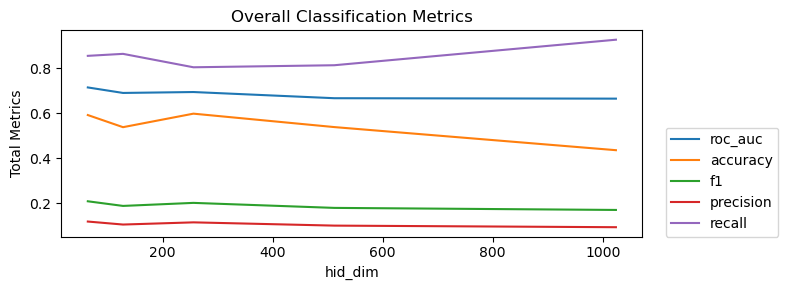

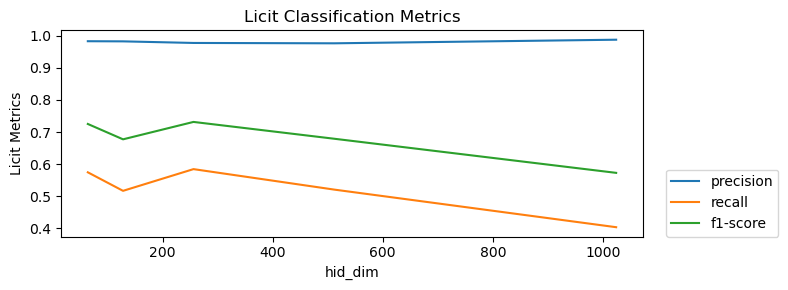

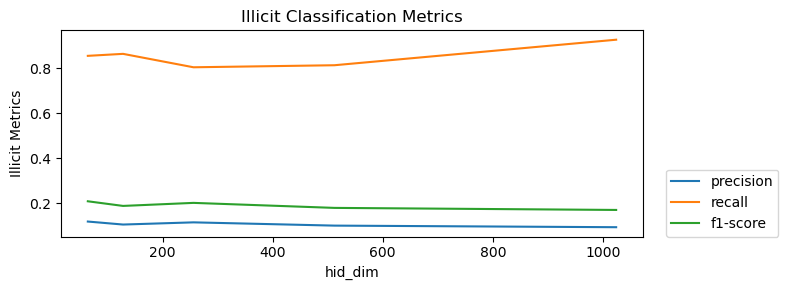

In [16]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Dropout

In [17]:
metrics = create_metrics()
para_change = "dropout"
para_list = [0.0, 0.1, 0.2, 0.3]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:08<01:17,  8.62s/it]

Avg Batch Loss: 1.018e+01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:17<01:09,  8.66s/it]

Avg Batch Loss: 1.213e+00, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:25<01:00,  8.61s/it]

Avg Batch Loss: 2.520e-01, 
Epoch 4/10
Avg Batch Loss: 5.001e-01, 


Epochs:  40%|████      | 4/10 [00:35<00:53,  8.84s/it]

Epoch 5/10
Avg Batch Loss: 1.475e-01, 


Epochs:  50%|█████     | 5/10 [07:34<13:04, 156.99s/it]

Epoch 6/10
Avg Batch Loss: 1.914e-01, 


Epochs:  60%|██████    | 6/10 [07:56<07:23, 110.90s/it]

Epoch 7/10


Epochs:  70%|███████   | 7/10 [08:13<04:01, 80.42s/it] 

Avg Batch Loss: 1.639e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [08:29<01:59, 59.74s/it]

Avg Batch Loss: 1.212e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [08:44<00:45, 45.83s/it]

Avg Batch Loss: 1.179e-01, 
Epoch 10/10
Avg Batch Loss: 1.139e-01, 


Epochs: 100%|██████████| 10/10 [08:59<00:00, 54.00s/it]


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:09<00:00,  4.76s/it]



Test Metrics:
Accuracy: 0.423
F1: 0.170
Precision: 0.094
Recall: 0.935

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.39      0.56     16513
           1       0.09      0.93      0.17      1118

    accuracy                           0.42     17631
   macro avg       0.54      0.66      0.36     17631
weighted avg       0.93      0.42      0.53     17631

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6614116410911466, 'accuracy': 0.4227780613691793, 'f1': 0.17037580500529878, 'precision': 0.09373037940622478, 'recall': 0.9347048300536672, 'classification_report': {'0': {'precision': 0.9887380438136377, 'recall': 0.38811845212862595, 'f1-score': 0.557425527288541, 'support': 16513.0}, '1': {'precision': 0.09373037940622478, 'recall': 0.9347048300536672, 'f1-score': 0.17037580500529878, 'support': 1118.0}, 'accuracy': 0.4227780613691793, 'macro avg': {'precision': 0.5412342116099312, 'recall': 0.66141

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:19<02:51, 19.05s/it]

Avg Batch Loss: 4.748e+00, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:38<02:34, 19.36s/it]

Avg Batch Loss: 6.949e-01, 
Epoch 3/10
Avg Batch Loss: 1.375e-01, 


Epochs:  30%|███       | 3/10 [00:57<02:12, 18.95s/it]

Epoch 4/10
Avg Batch Loss: 1.082e-01, 


Epochs:  40%|████      | 4/10 [01:19<02:02, 20.42s/it]

Epoch 5/10
Avg Batch Loss: 1.106e-01, 


Epochs:  50%|█████     | 5/10 [01:43<01:48, 21.64s/it]

Epoch 6/10
Avg Batch Loss: 9.371e-02, 


Epochs:  60%|██████    | 6/10 [02:03<01:24, 21.18s/it]

Epoch 7/10


Epochs:  70%|███████   | 7/10 [02:22<01:00, 20.26s/it]

Avg Batch Loss: 9.370e-02, 
Epoch 8/10
Avg Batch Loss: 8.794e-02, 


Epochs:  80%|████████  | 8/10 [02:40<00:39, 19.54s/it]

Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:59<00:19, 19.38s/it]

Avg Batch Loss: 8.310e-02, 
Epoch 10/10
Avg Batch Loss: 8.397e-02, 


Epochs: 100%|██████████| 10/10 [03:34<00:00, 21.47s/it]


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:11<00:00,  5.83s/it]



Test Metrics:
Accuracy: 0.757
F1: 0.236
Precision: 0.147
Recall: 0.596

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     16527
           1       0.15      0.60      0.24      1107

    accuracy                           0.76     17634
   macro avg       0.56      0.68      0.55     17634
weighted avg       0.91      0.76      0.82     17634

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6820202073866809, 'accuracy': 0.7570602245661789, 'f1': 0.23554603854389722, 'precision': 0.1467645096731154, 'recall': 0.5962059620596206, 'classification_report': {'0': {'precision': 0.9659739666590546, 'recall': 0.7678344527137412, 'f1-score': 0.8555825242718447, 'support': 16527.0}, '1': {'precision': 0.1467645096731154, 'recall': 0.5962059620596206, 'f1-score': 0.23554603854389722, 'support': 1107.0}, 'accuracy': 0.7570602245661789, 'macro avg': {'precision': 0.556369238166085, 'recall': 0.68202020

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
Avg Batch Loss: 5.338e+00, 


Epochs:  10%|█         | 1/10 [00:32<04:52, 32.49s/it]

Epoch 2/10
Avg Batch Loss: 1.053e+00, 


Epochs:  20%|██        | 2/10 [00:51<03:17, 24.74s/it]

Epoch 3/10


Epochs:  30%|███       | 3/10 [01:12<02:39, 22.82s/it]

Avg Batch Loss: 1.199e-01, 
Epoch 4/10
Avg Batch Loss: 1.176e-01, 


Epochs:  40%|████      | 4/10 [01:29<02:03, 20.59s/it]

Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:50<01:43, 20.69s/it]

Avg Batch Loss: 1.203e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [02:09<01:20, 20.09s/it]

Avg Batch Loss: 1.174e-01, 
Epoch 7/10
Avg Batch Loss: 1.127e-01, 


Epochs:  70%|███████   | 7/10 [02:25<00:56, 18.92s/it]

Epoch 8/10


Epochs:  80%|████████  | 8/10 [02:41<00:35, 17.99s/it]

Avg Batch Loss: 1.129e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:59<00:17, 17.89s/it]

Avg Batch Loss: 1.131e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [03:20<00:00, 20.01s/it]

Avg Batch Loss: 1.086e-01, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:09<00:00,  4.88s/it]



Test Metrics:
Accuracy: 0.682
F1: 0.213
Precision: 0.126
Recall: 0.684

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     16527
           1       0.13      0.68      0.21      1111

    accuracy                           0.68     17638
   macro avg       0.55      0.68      0.51     17638
weighted avg       0.92      0.68      0.76     17638

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6827796502648995, 'accuracy': 0.6816532486676494, 'f1': 0.2130343377715487, 'precision': 0.12616201859229748, 'recall': 0.684068406840684, 'classification_report': {'0': {'precision': 0.9697778543137593, 'recall': 0.6814908936891148, 'f1-score': 0.800469066486621, 'support': 16527.0}, '1': {'precision': 0.12616201859229748, 'recall': 0.684068406840684, 'f1-score': 0.2130343377715487, 'support': 1111.0}, 'accuracy': 0.6816532486676494, 'macro avg': {'precision': 0.5479699364530284, 'recall': 0.6827796502

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:23<03:29, 23.32s/it]

Avg Batch Loss: 5.028e+00, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:40<02:37, 19.67s/it]

Avg Batch Loss: 5.869e-01, 
Epoch 3/10
Avg Batch Loss: 1.258e-01, 


Epochs:  30%|███       | 3/10 [01:01<02:20, 20.14s/it]

Epoch 4/10
Avg Batch Loss: 1.255e-01, 


Epochs:  40%|████      | 4/10 [01:25<02:10, 21.82s/it]

Epoch 5/10
Avg Batch Loss: 1.215e-01, 


Epochs:  50%|█████     | 5/10 [01:42<01:40, 20.11s/it]

Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:59<01:15, 18.98s/it]

Avg Batch Loss: 1.146e-01, 
Epoch 7/10
Avg Batch Loss: 1.114e-01, 


Epochs:  70%|███████   | 7/10 [02:18<00:57, 19.12s/it]

Epoch 8/10


Epochs:  80%|████████  | 8/10 [02:35<00:36, 18.28s/it]

Avg Batch Loss: 1.114e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:51<00:17, 17.78s/it]

Avg Batch Loss: 1.085e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [03:08<00:00, 18.88s/it]

Avg Batch Loss: 1.053e-01, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Test Metrics:
Accuracy: 0.547
F1: 0.186
Precision: 0.105
Recall: 0.830

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.53      0.69     16516
           1       0.11      0.83      0.19      1101

    accuracy                           0.55     17617
   macro avg       0.54      0.68      0.44     17617
weighted avg       0.92      0.55      0.66     17617

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6793058293292894, 'accuracy': 0.5473122552080377, 'f1': 0.1864735285116801, 'precision': 0.10503332567225925, 'recall': 0.8301544050862852, 'classification_report': {'0': {'precision': 0.9790241166573191, 'recall': 0.5284572535722936, 'f1-score': 0.6864063544492942, 'support': 16516.0}, '1': {'precision': 0.10503332567225925, 'recall': 0.8301544050862852, 'f1-score': 0.1864735285116801, 'support': 1101.0}, 'accuracy': 0.5473122552080377, 'macro avg': {'precision': 0.5420287211647892, 'recall': 0.6793058

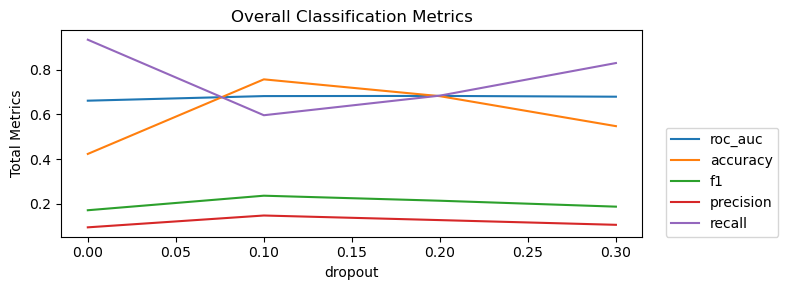

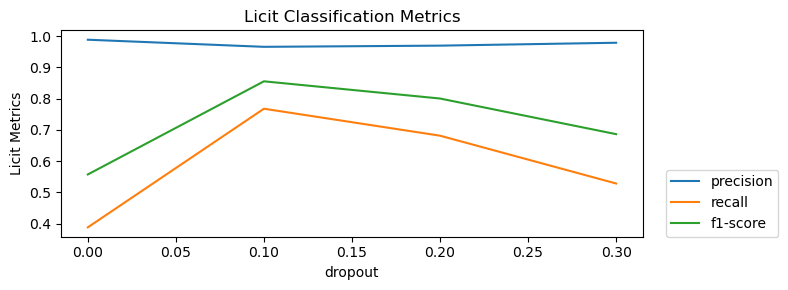

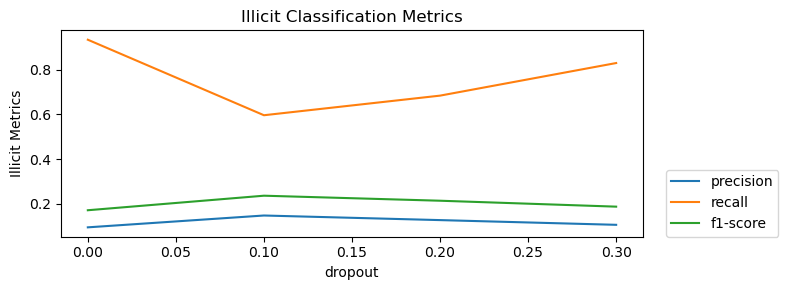

In [18]:
plot_metrics(metrics, para_list, para_change, x_log=False)

### Number of neighbors


In [19]:
metrics = create_metrics()
para_change = "num_neigh"
para_list = [[5, 5], [10, 10], [15, 15], [20, 20]]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:12<01:51, 12.42s/it]

Avg Batch Loss: 4.369e+00, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:25<01:43, 12.98s/it]

Avg Batch Loss: 6.272e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:37<01:26, 12.39s/it]

Avg Batch Loss: 1.662e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:48<01:11, 11.91s/it]

Avg Batch Loss: 1.118e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:59<00:57, 11.47s/it]

Avg Batch Loss: 1.167e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:10<00:44, 11.21s/it]

Avg Batch Loss: 1.047e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:20<00:32, 10.80s/it]

Avg Batch Loss: 9.523e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:30<00:21, 10.70s/it]

Avg Batch Loss: 9.389e-02, 
Epoch 9/10
Avg Batch Loss: 8.883e-02, 


Epochs:  90%|█████████ | 9/10 [01:42<00:11, 11.11s/it]

Epoch 10/10


Epochs: 100%|██████████| 10/10 [01:52<00:00, 11.30s/it]

Avg Batch Loss: 8.513e-02, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]



Test Metrics:
Accuracy: 0.661
F1: 0.214
Precision: 0.125
Recall: 0.728

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.66      0.78     16403
           1       0.13      0.73      0.21      1110

    accuracy                           0.66     17513
   macro avg       0.55      0.69      0.50     17513
weighted avg       0.92      0.66      0.75     17513

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6921356398769067, 'accuracy': 0.6608804887797636, 'f1': 0.21389808074123098, 'precision': 0.12536850271528316, 'recall': 0.7279279279279279, 'classification_report': {'0': {'precision': 0.9727141308276112, 'recall': 0.6563433518258855, 'f1-score': 0.7838083797459139, 'support': 16403.0}, '1': {'precision': 0.12536850271528316, 'recall': 0.7279279279279279, 'f1-score': 0.21389808074123098, 'support': 1110.0}, 'accuracy': 0.6608804887797636, 'macro avg': {'precision': 0.5490413167714472, 'recall': 0.69213

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:10<01:34, 10.51s/it]

Avg Batch Loss: 3.581e+00, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:20<01:22, 10.36s/it]

Avg Batch Loss: 5.903e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:30<01:11, 10.27s/it]

Avg Batch Loss: 1.097e-01, 
Epoch 4/10
Avg Batch Loss: 1.105e-01, 


Epochs:  40%|████      | 4/10 [00:40<01:01, 10.17s/it]

Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:50<00:50, 10.07s/it]

Avg Batch Loss: 1.011e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:01<00:41, 10.34s/it]

Avg Batch Loss: 9.344e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:13<00:32, 10.96s/it]

Avg Batch Loss: 9.218e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:24<00:21, 10.82s/it]

Avg Batch Loss: 8.902e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [01:34<00:10, 10.69s/it]

Avg Batch Loss: 8.551e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [01:47<00:00, 10.72s/it]

Avg Batch Loss: 8.412e-02, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:05<00:00,  2.97s/it]



Test Metrics:
Accuracy: 0.668
F1: 0.207
Precision: 0.122
Recall: 0.689

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     16508
           1       0.12      0.69      0.21      1109

    accuracy                           0.67     17617
   macro avg       0.55      0.68      0.50     17617
weighted avg       0.92      0.67      0.75     17617

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6777171240088419, 'accuracy': 0.6679343815632628, 'f1': 0.20710219571699648, 'precision': 0.12186951666932525, 'recall': 0.6889089269612263, 'classification_report': {'0': {'precision': 0.9695981670778991, 'recall': 0.6665253210564575, 'f1-score': 0.7899913842619184, 'support': 16508.0}, '1': {'precision': 0.12186951666932525, 'recall': 0.6889089269612263, 'f1-score': 0.20710219571699648, 'support': 1109.0}, 'accuracy': 0.6679343815632628, 'macro avg': {'precision': 0.5457338418736122, 'recall': 0.67771

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:11<01:46, 11.78s/it]

Avg Batch Loss: 4.425e+00, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:24<01:40, 12.59s/it]

Avg Batch Loss: 5.189e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:36<01:24, 12.05s/it]

Avg Batch Loss: 1.563e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:48<01:11, 11.97s/it]

Avg Batch Loss: 1.085e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:00<01:00, 12.08s/it]

Avg Batch Loss: 1.069e-01, 
Epoch 6/10
Avg Batch Loss: 9.783e-02, 


Epochs:  60%|██████    | 6/10 [01:13<00:49, 12.29s/it]

Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:25<00:36, 12.28s/it]

Avg Batch Loss: 9.605e-02, 
Epoch 8/10
Avg Batch Loss: 8.910e-02, 


Epochs:  80%|████████  | 8/10 [01:37<00:24, 12.36s/it]

Epoch 9/10
Avg Batch Loss: 8.635e-02, 


Epochs:  90%|█████████ | 9/10 [01:54<00:13, 13.72s/it]

Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:12<00:00, 13.23s/it]

Avg Batch Loss: 8.464e-02, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]



Test Metrics:
Accuracy: 0.675
F1: 0.207
Precision: 0.122
Recall: 0.680

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.80     16580
           1       0.12      0.68      0.21      1100

    accuracy                           0.68     17680
   macro avg       0.55      0.68      0.50     17680
weighted avg       0.92      0.68      0.76     17680

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6773642943305188, 'accuracy': 0.6750565610859729, 'f1': 0.20660129816323713, 'precision': 0.12180426640612278, 'recall': 0.68, 'classification_report': {'0': {'precision': 0.9694947569113441, 'recall': 0.6747285886610374, 'f1-score': 0.7956897471460578, 'support': 16580.0}, '1': {'precision': 0.12180426640612278, 'recall': 0.68, 'f1-score': 0.20660129816323713, 'support': 1100.0}, 'accuracy': 0.6750565610859729, 'macro avg': {'precision': 0.5456495116587334, 'recall': 0.6773642943305187, 'f1-score': 0.5

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:11<01:47, 11.91s/it]

Avg Batch Loss: 4.933e+00, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:23<01:33, 11.67s/it]

Avg Batch Loss: 8.525e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:34<01:19, 11.33s/it]

Avg Batch Loss: 1.179e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:45<01:07, 11.30s/it]

Avg Batch Loss: 1.314e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:56<00:55, 11.19s/it]

Avg Batch Loss: 1.161e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:08<00:45, 11.38s/it]

Avg Batch Loss: 1.158e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:19<00:33, 11.30s/it]

Avg Batch Loss: 1.149e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:30<00:22, 11.19s/it]

Avg Batch Loss: 1.125e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [01:42<00:11, 11.54s/it]

Avg Batch Loss: 1.097e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [01:53<00:00, 11.40s/it]

Avg Batch Loss: 1.086e-01, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.40s/it]


Test Metrics:
Accuracy: 0.634
F1: 0.212
Precision: 0.123
Recall: 0.782

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.62      0.76     16612
           1       0.12      0.78      0.21      1118

    accuracy                           0.63     17730
   macro avg       0.55      0.70      0.49     17730
weighted avg       0.92      0.63      0.73     17730

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.7026692452855384, 'accuracy': 0.6335589396503102, 'f1': 0.21200727713765918, 'precision': 0.12263224358074927, 'recall': 0.7817531305903399, 'classification_report': {'0': {'precision': 0.9769876450061303, 'recall': 0.6235853599807368, 'f1-score': 0.7612713577071468, 'support': 16612.0}, '1': {'precision': 0.12263224358074927, 'recall': 0.7817531305903399, 'f1-score': 0.21200727713765918, 'support': 1118.0}, 'accuracy': 0.6335589396503102, 'macro avg': {'precision': 0.5498099442934398, 'recall': 0.70266

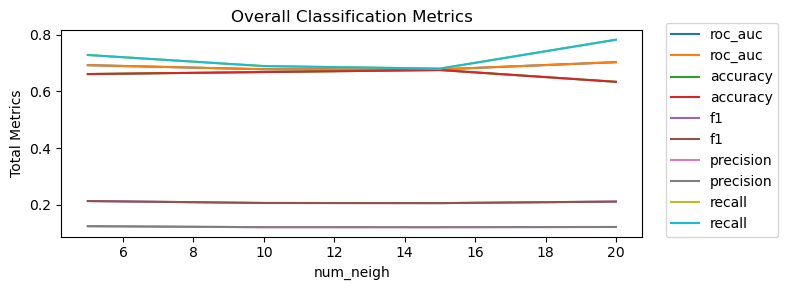

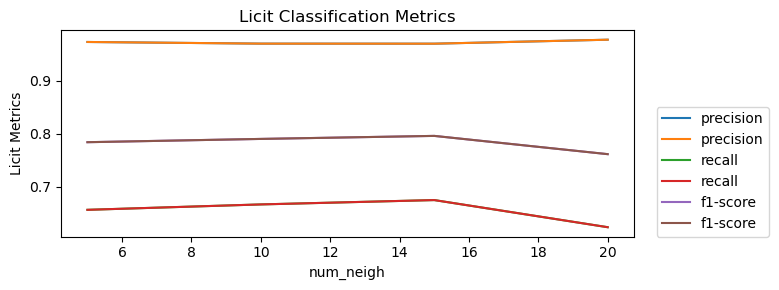

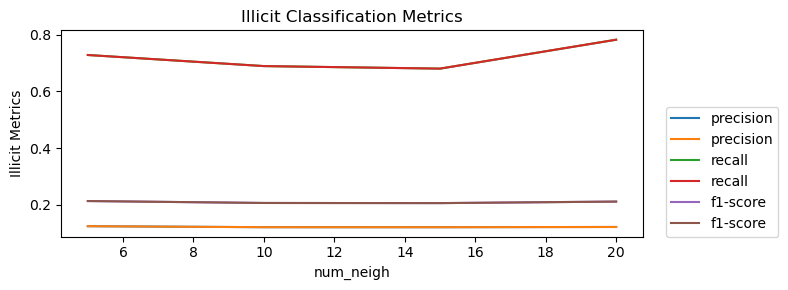

In [20]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Epochs

In [13]:
metrics = create_metrics()
para_change = "epoch"
para_list = [10, 20 , 30 , 40, 50]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:13<02:04, 13.88s/it]

Avg Batch Loss: 4.860e+00, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:25<01:39, 12.42s/it]

Avg Batch Loss: 1.113e+00, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:36<01:21, 11.71s/it]

Avg Batch Loss: 1.232e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:46<01:08, 11.36s/it]

Avg Batch Loss: 1.179e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:57<00:55, 11.17s/it]

Avg Batch Loss: 1.216e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:08<00:44, 11.17s/it]

Avg Batch Loss: 1.194e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:19<00:33, 11.08s/it]

Avg Batch Loss: 1.160e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:30<00:22, 11.01s/it]

Avg Batch Loss: 1.137e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [01:41<00:11, 11.03s/it]

Avg Batch Loss: 1.122e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [01:52<00:00, 11.27s/it]

Avg Batch Loss: 1.114e-01, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.37s/it]



Test Metrics:
Accuracy: 0.764
F1: 0.235
Precision: 0.148
Recall: 0.573

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86     16550
           1       0.15      0.57      0.24      1119

    accuracy                           0.76     17669
   macro avg       0.56      0.68      0.55     17669
weighted avg       0.91      0.76      0.82     17669

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6750569266365901, 'accuracy': 0.7643330126209746, 'f1': 0.2354021300036724, 'precision': 0.14813958862953547, 'recall': 0.5728328865058088, 'classification_report': {'0': {'precision': 0.964173287363214, 'recall': 0.7772809667673716, 'f1-score': 0.8606985146527499, 'support': 16550.0}, '1': {'precision': 0.14813958862953547, 'recall': 0.5728328865058088, 'f1-score': 0.2354021300036724, 'support': 1119.0}, 'accuracy': 0.7643330126209746, 'macro avg': {'precision': 0.5561564379963747, 'recall': 0.67505692

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20


Epochs:   5%|▌         | 1/20 [00:11<03:34, 11.31s/it]

Avg Batch Loss: 2.572e+00, 
Epoch 2/20


Epochs:  10%|█         | 2/20 [00:22<03:19, 11.09s/it]

Avg Batch Loss: 7.847e-01, 
Epoch 3/20


Epochs:  15%|█▌        | 3/20 [00:33<03:06, 10.95s/it]

Avg Batch Loss: 1.293e-01, 
Epoch 4/20


Epochs:  20%|██        | 4/20 [00:43<02:54, 10.91s/it]

Avg Batch Loss: 1.460e-01, 
Epoch 5/20


Epochs:  25%|██▌       | 5/20 [00:54<02:43, 10.89s/it]

Avg Batch Loss: 1.029e-01, 
Epoch 6/20


Epochs:  30%|███       | 6/20 [01:05<02:33, 10.93s/it]

Avg Batch Loss: 9.649e-02, 
Epoch 7/20


Epochs:  35%|███▌      | 7/20 [01:16<02:20, 10.84s/it]

Avg Batch Loss: 9.400e-02, 
Epoch 8/20


Epochs:  40%|████      | 8/20 [01:27<02:11, 10.99s/it]

Avg Batch Loss: 8.798e-02, 
Epoch 9/20


Epochs:  45%|████▌     | 9/20 [01:38<02:00, 10.98s/it]

Avg Batch Loss: 8.811e-02, 
Epoch 10/20
Avg Batch Loss: 8.454e-02, 


Epochs:  50%|█████     | 10/20 [01:49<01:49, 10.97s/it]

Epoch 11/20


Epochs:  55%|█████▌    | 11/20 [02:01<01:40, 11.12s/it]

Avg Batch Loss: 8.222e-02, 
Epoch 12/20


Epochs:  60%|██████    | 12/20 [02:12<01:29, 11.15s/it]

Avg Batch Loss: 7.952e-02, 
Epoch 13/20


Epochs:  65%|██████▌   | 13/20 [02:23<01:17, 11.03s/it]

Avg Batch Loss: 7.646e-02, 
Epoch 14/20


Epochs:  70%|███████   | 14/20 [02:35<01:08, 11.36s/it]

Avg Batch Loss: 7.515e-02, 
Epoch 15/20


Epochs:  75%|███████▌  | 15/20 [02:47<00:58, 11.64s/it]

Avg Batch Loss: 7.299e-02, 
Epoch 16/20


Epochs:  80%|████████  | 16/20 [02:58<00:46, 11.57s/it]

Avg Batch Loss: 7.040e-02, 
Epoch 17/20


Epochs:  85%|████████▌ | 17/20 [03:10<00:34, 11.59s/it]

Avg Batch Loss: 6.849e-02, 
Epoch 18/20


Epochs:  90%|█████████ | 18/20 [03:23<00:23, 11.90s/it]

Avg Batch Loss: 6.706e-02, 
Epoch 19/20


Epochs:  95%|█████████▌| 19/20 [03:35<00:12, 12.17s/it]

Avg Batch Loss: 6.573e-02, 
Epoch 20/20


Epochs: 100%|██████████| 20/20 [08:29<00:00, 25.49s/it]

Avg Batch Loss: 6.446e-02, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:08<00:00,  4.35s/it]



Test Metrics:
Accuracy: 0.572
F1: 0.193
Precision: 0.109
Recall: 0.817

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.56      0.71     16641
           1       0.11      0.82      0.19      1112

    accuracy                           0.57     17753
   macro avg       0.54      0.69      0.45     17753
weighted avg       0.92      0.57      0.68     17753

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6863205217329651, 'accuracy': 0.5716216977412268, 'f1': 0.1929321872015282, 'precision': 0.10937311996149682, 'recall': 0.8174460431654677, 'classification_report': {'0': {'precision': 0.9785003177292947, 'recall': 0.5551950003004628, 'f1-score': 0.708430778668098, 'support': 16641.0}, '1': {'precision': 0.10937311996149682, 'recall': 0.8174460431654677, 'f1-score': 0.1929321872015282, 'support': 1112.0}, 'accuracy': 0.5716216977412268, 'macro avg': {'precision': 0.5439367188453957, 'recall': 0.68632052

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30


Epochs:   3%|▎         | 1/30 [00:13<06:29, 13.44s/it]

Avg Batch Loss: 8.696e-01, 
Epoch 2/30


Epochs:   7%|▋         | 2/30 [00:26<06:08, 13.17s/it]

Avg Batch Loss: 5.463e+00, 
Epoch 3/30


Epochs:  10%|█         | 3/30 [00:39<05:52, 13.07s/it]

Avg Batch Loss: 9.412e-01, 
Epoch 4/30


Epochs:  13%|█▎        | 4/30 [00:51<05:30, 12.72s/it]

Avg Batch Loss: 1.526e-01, 
Epoch 5/30


Epochs:  17%|█▋        | 5/30 [01:02<05:00, 12.01s/it]

Avg Batch Loss: 2.575e-01, 
Epoch 6/30


Epochs:  20%|██        | 6/30 [01:13<04:39, 11.63s/it]

Avg Batch Loss: 1.030e-01, 
Epoch 7/30


Epochs:  23%|██▎       | 7/30 [01:24<04:22, 11.39s/it]

Avg Batch Loss: 1.115e-01, 
Epoch 8/30


Epochs:  27%|██▋       | 8/30 [01:35<04:08, 11.29s/it]

Avg Batch Loss: 1.120e-01, 
Epoch 9/30


Epochs:  30%|███       | 9/30 [01:46<03:58, 11.37s/it]

Avg Batch Loss: 1.066e-01, 
Epoch 10/30


Epochs:  33%|███▎      | 10/30 [01:57<03:45, 11.29s/it]

Avg Batch Loss: 1.021e-01, 
Epoch 11/30


Epochs:  37%|███▋      | 11/30 [02:08<03:32, 11.20s/it]

Avg Batch Loss: 9.768e-02, 
Epoch 12/30


Epochs:  40%|████      | 12/30 [02:20<03:22, 11.23s/it]

Avg Batch Loss: 9.288e-02, 
Epoch 13/30


Epochs:  43%|████▎     | 13/30 [02:32<03:18, 11.70s/it]

Avg Batch Loss: 8.690e-02, 
Epoch 14/30


Epochs:  47%|████▋     | 14/30 [02:44<03:07, 11.69s/it]

Avg Batch Loss: 8.095e-02, 
Epoch 15/30


Epochs:  50%|█████     | 15/30 [02:55<02:52, 11.49s/it]

Avg Batch Loss: 7.813e-02, 
Epoch 16/30


Epochs:  53%|█████▎    | 16/30 [03:06<02:40, 11.44s/it]

Avg Batch Loss: 7.583e-02, 
Epoch 17/30


Epochs:  57%|█████▋    | 17/30 [03:17<02:26, 11.30s/it]

Avg Batch Loss: 7.202e-02, 
Epoch 18/30


Epochs:  60%|██████    | 18/30 [03:28<02:13, 11.09s/it]

Avg Batch Loss: 6.910e-02, 
Epoch 19/30


Epochs:  63%|██████▎   | 19/30 [03:39<02:01, 11.06s/it]

Avg Batch Loss: 6.737e-02, 
Epoch 20/30


Epochs:  67%|██████▋   | 20/30 [03:50<01:49, 10.98s/it]

Avg Batch Loss: 6.382e-02, 
Epoch 21/30


Epochs:  70%|███████   | 21/30 [04:01<01:39, 11.01s/it]

Avg Batch Loss: 6.291e-02, 
Epoch 22/30


Epochs:  73%|███████▎  | 22/30 [04:12<01:29, 11.17s/it]

Avg Batch Loss: 6.113e-02, 
Epoch 23/30


Epochs:  77%|███████▋  | 23/30 [04:23<01:17, 11.08s/it]

Avg Batch Loss: 5.947e-02, 
Epoch 24/30


Epochs:  80%|████████  | 24/30 [04:34<01:05, 10.97s/it]

Avg Batch Loss: 5.843e-02, 
Epoch 25/30


Epochs:  83%|████████▎ | 25/30 [04:45<00:55, 11.00s/it]

Avg Batch Loss: 5.705e-02, 
Epoch 26/30


Epochs:  87%|████████▋ | 26/30 [04:57<00:45, 11.30s/it]

Avg Batch Loss: 5.483e-02, 
Epoch 27/30


Epochs:  90%|█████████ | 27/30 [05:09<00:34, 11.58s/it]

Avg Batch Loss: 5.490e-02, 
Epoch 28/30


Epochs:  93%|█████████▎| 28/30 [05:21<00:23, 11.58s/it]

Avg Batch Loss: 5.299e-02, 
Epoch 29/30


Epochs:  97%|█████████▋| 29/30 [05:32<00:11, 11.55s/it]

Avg Batch Loss: 5.189e-02, 
Epoch 30/30


Epochs: 100%|██████████| 30/30 [05:43<00:00, 11.47s/it]

Avg Batch Loss: 5.058e-02, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:05<00:00,  2.55s/it]



Test Metrics:
Accuracy: 0.872
F1: 0.336
Precision: 0.249
Recall: 0.518

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     16635
           1       0.25      0.52      0.34      1109

    accuracy                           0.87     17744
   macro avg       0.61      0.71      0.63     17744
weighted avg       0.92      0.87      0.89     17744

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.706672678088368, 'accuracy': 0.8721257889990983, 'f1': 0.33596722270997953, 'precision': 0.24870017331022531, 'recall': 0.5175834084761046, 'classification_report': {'0': {'precision': 0.965340761855403, 'recall': 0.8957619477006312, 'f1-score': 0.9292507249540083, 'support': 16635.0}, '1': {'precision': 0.24870017331022531, 'recall': 0.5175834084761046, 'f1-score': 0.33596722270997953, 'support': 1109.0}, 'accuracy': 0.8721257889990983, 'macro avg': {'precision': 0.6070204675828141, 'recall': 0.7066726

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40


Epochs:   2%|▎         | 1/40 [00:11<07:24, 11.41s/it]

Avg Batch Loss: 1.915e+01, 
Epoch 2/40


Epochs:   5%|▌         | 2/40 [00:22<07:06, 11.23s/it]

Avg Batch Loss: 1.156e+00, 
Epoch 3/40


Epochs:   8%|▊         | 3/40 [00:35<07:21, 11.92s/it]

Avg Batch Loss: 1.890e-01, 
Epoch 4/40


Epochs:  10%|█         | 4/40 [00:46<07:03, 11.75s/it]

Avg Batch Loss: 1.238e-01, 
Epoch 5/40


Epochs:  12%|█▎        | 5/40 [00:57<06:41, 11.48s/it]

Avg Batch Loss: 1.306e-01, 
Epoch 6/40


Epochs:  15%|█▌        | 6/40 [01:08<06:22, 11.25s/it]

Avg Batch Loss: 1.073e-01, 
Epoch 7/40


Epochs:  18%|█▊        | 7/40 [01:19<06:06, 11.12s/it]

Avg Batch Loss: 1.083e-01, 
Epoch 8/40


Epochs:  20%|██        | 8/40 [01:30<05:57, 11.17s/it]

Avg Batch Loss: 9.859e-02, 
Epoch 9/40


Epochs:  22%|██▎       | 9/40 [01:41<05:44, 11.10s/it]

Avg Batch Loss: 1.013e-01, 
Epoch 10/40


Epochs:  25%|██▌       | 10/40 [01:53<05:37, 11.25s/it]

Avg Batch Loss: 9.678e-02, 
Epoch 11/40


Epochs:  28%|██▊       | 11/40 [02:04<05:24, 11.17s/it]

Avg Batch Loss: 9.472e-02, 
Epoch 12/40


Epochs:  30%|███       | 12/40 [02:15<05:14, 11.22s/it]

Avg Batch Loss: 9.283e-02, 
Epoch 13/40


Epochs:  32%|███▎      | 13/40 [02:27<05:05, 11.31s/it]

Avg Batch Loss: 8.945e-02, 
Epoch 14/40
Avg Batch Loss: 8.792e-02, 


Epochs:  35%|███▌      | 14/40 [06:15<33:16, 76.78s/it]

Epoch 15/40
Avg Batch Loss: 8.616e-02, 


Epochs:  38%|███▊      | 15/40 [06:31<24:24, 58.57s/it]

Epoch 16/40


Epochs:  40%|████      | 16/40 [06:45<18:05, 45.21s/it]

Avg Batch Loss: 8.419e-02, 
Epoch 17/40


Epochs:  42%|████▎     | 17/40 [06:57<13:29, 35.20s/it]

Avg Batch Loss: 8.155e-02, 
Epoch 18/40


Epochs:  45%|████▌     | 18/40 [07:08<10:16, 28.01s/it]

Avg Batch Loss: 7.812e-02, 
Epoch 19/40


Epochs:  48%|████▊     | 19/40 [07:19<08:00, 22.88s/it]

Avg Batch Loss: 7.643e-02, 
Epoch 20/40


Epochs:  50%|█████     | 20/40 [07:30<06:25, 19.28s/it]

Avg Batch Loss: 7.345e-02, 
Epoch 21/40


Epochs:  52%|█████▎    | 21/40 [07:41<05:18, 16.76s/it]

Avg Batch Loss: 7.191e-02, 
Epoch 22/40


Epochs:  55%|█████▌    | 22/40 [07:52<04:30, 15.02s/it]

Avg Batch Loss: 6.917e-02, 
Epoch 23/40


Epochs:  57%|█████▊    | 23/40 [08:03<03:54, 13.78s/it]

Avg Batch Loss: 6.834e-02, 
Epoch 24/40


Epochs:  60%|██████    | 24/40 [08:14<03:27, 12.97s/it]

Avg Batch Loss: 6.619e-02, 
Epoch 25/40


Epochs:  62%|██████▎   | 25/40 [08:25<03:06, 12.45s/it]

Avg Batch Loss: 6.471e-02, 
Epoch 26/40


Epochs:  65%|██████▌   | 26/40 [08:38<02:53, 12.41s/it]

Avg Batch Loss: 6.263e-02, 
Epoch 27/40


Epochs:  68%|██████▊   | 27/40 [08:49<02:37, 12.09s/it]

Avg Batch Loss: 6.215e-02, 
Epoch 28/40


Epochs:  70%|███████   | 28/40 [09:00<02:21, 11.79s/it]

Avg Batch Loss: 5.950e-02, 
Epoch 29/40


Epochs:  72%|███████▎  | 29/40 [09:11<02:06, 11.51s/it]

Avg Batch Loss: 5.975e-02, 
Epoch 30/40


Epochs:  75%|███████▌  | 30/40 [09:22<01:53, 11.35s/it]

Avg Batch Loss: 5.894e-02, 
Epoch 31/40


Epochs:  78%|███████▊  | 31/40 [09:33<01:41, 11.27s/it]

Avg Batch Loss: 5.728e-02, 
Epoch 32/40


Epochs:  80%|████████  | 32/40 [09:44<01:30, 11.30s/it]

Avg Batch Loss: 5.645e-02, 
Epoch 33/40


Epochs:  82%|████████▎ | 33/40 [09:55<01:18, 11.22s/it]

Avg Batch Loss: 5.489e-02, 
Epoch 34/40


Epochs:  85%|████████▌ | 34/40 [10:06<01:06, 11.13s/it]

Avg Batch Loss: 5.389e-02, 
Epoch 35/40


Epochs:  88%|████████▊ | 35/40 [10:18<00:56, 11.37s/it]

Avg Batch Loss: 5.325e-02, 
Epoch 36/40


Epochs:  90%|█████████ | 36/40 [10:29<00:45, 11.34s/it]

Avg Batch Loss: 5.176e-02, 
Epoch 37/40


Epochs:  92%|█████████▎| 37/40 [10:40<00:33, 11.21s/it]

Avg Batch Loss: 5.139e-02, 
Epoch 38/40


Epochs:  95%|█████████▌| 38/40 [10:52<00:22, 11.25s/it]

Avg Batch Loss: 5.092e-02, 
Epoch 39/40


Epochs:  98%|█████████▊| 39/40 [11:03<00:11, 11.22s/it]

Avg Batch Loss: 4.988e-02, 
Epoch 40/40


Epochs: 100%|██████████| 40/40 [11:14<00:00, 16.85s/it]

Avg Batch Loss: 4.851e-02, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.40s/it]



Test Metrics:
Accuracy: 0.826
F1: 0.272
Precision: 0.185
Recall: 0.515

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     16499
           1       0.19      0.51      0.27      1113

    accuracy                           0.83     17612
   macro avg       0.57      0.68      0.59     17612
weighted avg       0.91      0.83      0.86     17612

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6809532195776302, 'accuracy': 0.8260844878491937, 'f1': 0.2722736992159658, 'precision': 0.18507751937984496, 'recall': 0.5148247978436657, 'classification_report': {'0': {'precision': 0.9627996693303941, 'recall': 0.8470816413115947, 'f1-score': 0.9012413348379816, 'support': 16499.0}, '1': {'precision': 0.18507751937984496, 'recall': 0.5148247978436657, 'f1-score': 0.2722736992159658, 'support': 1113.0}, 'accuracy': 0.8260844878491937, 'macro avg': {'precision': 0.5739385943551195, 'recall': 0.6809532

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50


Epochs:   2%|▏         | 1/50 [00:11<09:16, 11.36s/it]

Avg Batch Loss: 4.991e+00, 
Epoch 2/50


Epochs:   4%|▍         | 2/50 [00:22<09:04, 11.35s/it]

Avg Batch Loss: 9.050e-01, 
Epoch 3/50


Epochs:   6%|▌         | 3/50 [00:33<08:44, 11.16s/it]

Avg Batch Loss: 1.169e-01, 
Epoch 4/50


Epochs:   8%|▊         | 4/50 [00:44<08:28, 11.06s/it]

Avg Batch Loss: 1.175e-01, 
Epoch 5/50


Epochs:  10%|█         | 5/50 [00:55<08:14, 10.99s/it]

Avg Batch Loss: 1.202e-01, 
Epoch 6/50


Epochs:  12%|█▏        | 6/50 [01:06<08:02, 10.97s/it]

Avg Batch Loss: 1.204e-01, 
Epoch 7/50


Epochs:  14%|█▍        | 7/50 [01:17<07:50, 10.95s/it]

Avg Batch Loss: 1.175e-01, 
Epoch 8/50


Epochs:  16%|█▌        | 8/50 [01:28<07:43, 11.02s/it]

Avg Batch Loss: 1.140e-01, 
Epoch 9/50


Epochs:  18%|█▊        | 9/50 [01:40<07:45, 11.36s/it]

Avg Batch Loss: 1.110e-01, 
Epoch 10/50


Epochs:  20%|██        | 10/50 [01:51<07:30, 11.26s/it]

Avg Batch Loss: 1.104e-01, 
Epoch 11/50


Epochs:  22%|██▏       | 11/50 [02:03<07:25, 11.42s/it]

Avg Batch Loss: 1.089e-01, 
Epoch 12/50


Epochs:  24%|██▍       | 12/50 [02:15<07:27, 11.77s/it]

Avg Batch Loss: 1.067e-01, 
Epoch 13/50


Epochs:  26%|██▌       | 13/50 [02:29<07:31, 12.19s/it]

Avg Batch Loss: 1.058e-01, 
Epoch 14/50


Epochs:  28%|██▊       | 14/50 [02:40<07:13, 12.05s/it]

Avg Batch Loss: 1.045e-01, 
Epoch 15/50


Epochs:  30%|███       | 15/50 [02:51<06:52, 11.77s/it]

Avg Batch Loss: 1.028e-01, 
Epoch 16/50


Epochs:  32%|███▏      | 16/50 [03:03<06:36, 11.67s/it]

Avg Batch Loss: 1.025e-01, 
Epoch 17/50


Epochs:  34%|███▍      | 17/50 [03:14<06:22, 11.58s/it]

Avg Batch Loss: 1.003e-01, 
Epoch 18/50


Epochs:  36%|███▌      | 18/50 [03:26<06:15, 11.74s/it]

Avg Batch Loss: 1.010e-01, 
Epoch 19/50


Epochs:  38%|███▊      | 19/50 [03:37<05:55, 11.47s/it]

Avg Batch Loss: 1.008e-01, 
Epoch 20/50


Epochs:  40%|████      | 20/50 [03:48<05:39, 11.31s/it]

Avg Batch Loss: 9.913e-02, 
Epoch 21/50


Epochs:  42%|████▏     | 21/50 [03:59<05:22, 11.12s/it]

Avg Batch Loss: 9.666e-02, 
Epoch 22/50


Epochs:  44%|████▍     | 22/50 [04:10<05:10, 11.07s/it]

Avg Batch Loss: 9.597e-02, 
Epoch 23/50


Epochs:  46%|████▌     | 23/50 [04:21<04:59, 11.10s/it]

Avg Batch Loss: 9.562e-02, 
Epoch 24/50


Epochs:  48%|████▊     | 24/50 [04:32<04:46, 11.03s/it]

Avg Batch Loss: 9.455e-02, 
Epoch 25/50


Epochs:  50%|█████     | 25/50 [04:43<04:37, 11.11s/it]

Avg Batch Loss: 9.318e-02, 
Epoch 26/50


Epochs:  52%|█████▏    | 26/50 [04:54<04:28, 11.17s/it]

Avg Batch Loss: 9.188e-02, 
Epoch 27/50


Epochs:  54%|█████▍    | 27/50 [05:06<04:16, 11.15s/it]

Avg Batch Loss: 9.053e-02, 
Epoch 28/50


Epochs:  56%|█████▌    | 28/50 [05:16<04:03, 11.06s/it]

Avg Batch Loss: 8.863e-02, 
Epoch 29/50


Epochs:  58%|█████▊    | 29/50 [05:27<03:50, 10.96s/it]

Avg Batch Loss: 8.924e-02, 
Epoch 30/50


Epochs:  60%|██████    | 30/50 [05:38<03:39, 10.96s/it]

Avg Batch Loss: 8.791e-02, 
Epoch 31/50


Epochs:  62%|██████▏   | 31/50 [05:50<03:35, 11.33s/it]

Avg Batch Loss: 8.619e-02, 
Epoch 32/50


Epochs:  64%|██████▍   | 32/50 [06:02<03:25, 11.44s/it]

Avg Batch Loss: 8.535e-02, 
Epoch 33/50


Epochs:  66%|██████▌   | 33/50 [06:13<03:14, 11.45s/it]

Avg Batch Loss: 8.463e-02, 
Epoch 34/50


Epochs:  68%|██████▊   | 34/50 [06:25<03:01, 11.36s/it]

Avg Batch Loss: 8.408e-02, 
Epoch 35/50


Epochs:  70%|███████   | 35/50 [06:36<02:49, 11.31s/it]

Avg Batch Loss: 8.245e-02, 
Epoch 36/50


Epochs:  72%|███████▏  | 36/50 [06:47<02:39, 11.39s/it]

Avg Batch Loss: 8.160e-02, 
Epoch 37/50


Epochs:  74%|███████▍  | 37/50 [06:58<02:26, 11.25s/it]

Avg Batch Loss: 7.945e-02, 
Epoch 38/50


Epochs:  76%|███████▌  | 38/50 [07:09<02:14, 11.19s/it]

Avg Batch Loss: 7.813e-02, 
Epoch 39/50


Epochs:  78%|███████▊  | 39/50 [07:21<02:03, 11.22s/it]

Avg Batch Loss: 7.812e-02, 
Epoch 40/50


Epochs:  80%|████████  | 40/50 [07:33<01:55, 11.59s/it]

Avg Batch Loss: 7.772e-02, 
Epoch 41/50
Avg Batch Loss: 7.630e-02, 


Epochs:  82%|████████▏ | 41/50 [07:47<01:49, 12.18s/it]

Epoch 42/50


Epochs:  84%|████████▍ | 42/50 [07:58<01:36, 12.05s/it]

Avg Batch Loss: 7.522e-02, 
Epoch 43/50


Epochs:  86%|████████▌ | 43/50 [08:09<01:22, 11.76s/it]

Avg Batch Loss: 7.446e-02, 
Epoch 44/50


Epochs:  88%|████████▊ | 44/50 [08:21<01:09, 11.62s/it]

Avg Batch Loss: 7.289e-02, 
Epoch 45/50


Epochs:  90%|█████████ | 45/50 [08:32<00:57, 11.59s/it]

Avg Batch Loss: 7.180e-02, 
Epoch 46/50


Epochs:  92%|█████████▏| 46/50 [08:44<00:46, 11.52s/it]

Avg Batch Loss: 7.164e-02, 
Epoch 47/50


Epochs:  94%|█████████▍| 47/50 [08:55<00:34, 11.47s/it]

Avg Batch Loss: 7.048e-02, 
Epoch 48/50


Epochs:  96%|█████████▌| 48/50 [09:06<00:22, 11.31s/it]

Avg Batch Loss: 7.065e-02, 
Epoch 49/50


Epochs:  98%|█████████▊| 49/50 [09:17<00:11, 11.29s/it]

Avg Batch Loss: 6.897e-02, 
Epoch 50/50


Epochs: 100%|██████████| 50/50 [09:28<00:00, 11.38s/it]

Avg Batch Loss: 6.783e-02, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:05<00:00,  2.65s/it]


Test Metrics:
Accuracy: 0.528
F1: 0.190
Precision: 0.106
Recall: 0.890

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.50      0.67     16628
           1       0.11      0.89      0.19      1103

    accuracy                           0.53     17731
   macro avg       0.55      0.70      0.43     17731
weighted avg       0.93      0.53      0.64     17731

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6969237079707605, 'accuracy': 0.5276070159607467, 'f1': 0.1899419729206963, 'precision': 0.10631157302154379, 'recall': 0.8902991840435177, 'classification_report': {'0': {'precision': 0.9857546503414175, 'recall': 0.5035482318980034, 'f1-score': 0.6665870551707667, 'support': 16628.0}, '1': {'precision': 0.10631157302154379, 'recall': 0.8902991840435177, 'f1-score': 0.1899419729206963, 'support': 1103.0}, 'accuracy': 0.5276070159607467, 'macro avg': {'precision': 0.5460331116814806, 'recall': 0.6969237

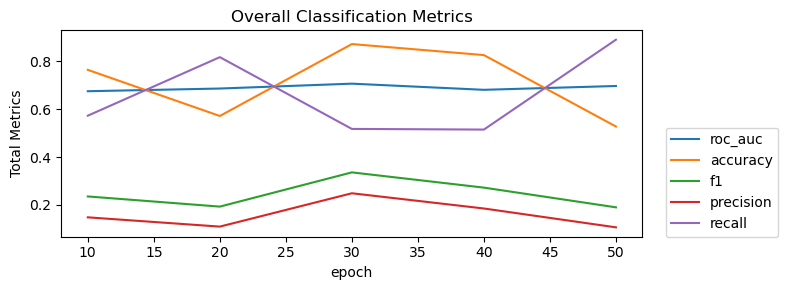

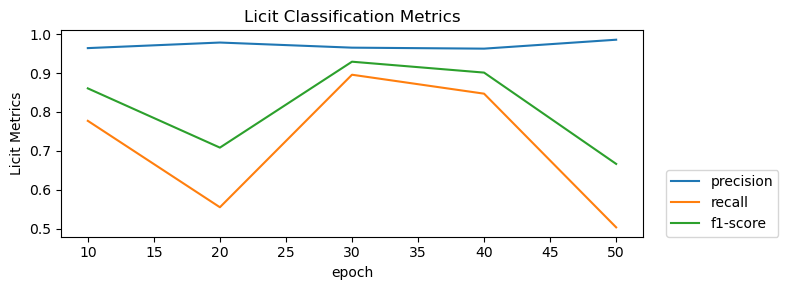

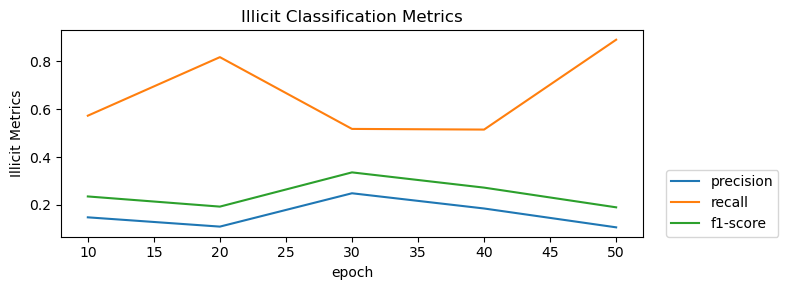

: 

In [ ]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Focal Loss

In [6]:
metrics = create_metrics()
para_change = "gamma"
para_list = [0.5, 1.0, 1.5, 2.0]

metrics = hyperparameter_loop("loss", para_change, para_list, metrics)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:05<00:50,  5.56s/it]

Avg Batch Loss: nan, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:10<00:43,  5.44s/it]

Avg Batch Loss: nan, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:15<00:35,  5.09s/it]

Avg Batch Loss: nan, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:20<00:29,  4.87s/it]

Avg Batch Loss: nan, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:24<00:23,  4.73s/it]

Avg Batch Loss: nan, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:29<00:18,  4.65s/it]

Avg Batch Loss: nan, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:33<00:13,  4.65s/it]

Avg Batch Loss: nan, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:38<00:09,  4.57s/it]

Avg Batch Loss: nan, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:42<00:04,  4.53s/it]

Avg Batch Loss: nan, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:46<00:00,  4.70s/it]

Avg Batch Loss: nan, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]



Test Metrics:
Accuracy: 0.936
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16419
           1       0.00      0.00      0.00      1119

    accuracy                           0.94     17538
   macro avg       0.47      0.50      0.48     17538
weighted avg       0.88      0.94      0.91     17538

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9361956893602463, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9361956893602463, 'recall': 1.0, 'f1-score': 0.9670465588832936, 'support': 16419.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1119.0}, 'accuracy': 0.9361956893602463, 'macro avg': {'precision': 0.46809784468012317, 'recall': 0.5, 'f1-score': 0.4835232794416468, 'support': 17538.0}, 'weighted avg': {'precision': 0.8764623687767069, 'recall': 0.9361956893

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:04<00:42,  4.68s/it]

Avg Batch Loss: 3.297e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:09<00:36,  4.57s/it]

Avg Batch Loss: 1.076e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:13<00:31,  4.50s/it]

Avg Batch Loss: 1.011e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:18<00:27,  4.62s/it]

Avg Batch Loss: 9.765e-02, 
Epoch 5/10
Avg Batch Loss: 9.342e-02, 


Epochs:  50%|█████     | 5/10 [00:22<00:22,  4.52s/it]

Epoch 6/10
Avg Batch Loss: 9.101e-02, 


Epochs:  60%|██████    | 6/10 [00:27<00:18,  4.68s/it]

Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:32<00:13,  4.58s/it]

Avg Batch Loss: 8.288e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:36<00:09,  4.66s/it]

Avg Batch Loss: 7.893e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:41<00:04,  4.75s/it]

Avg Batch Loss: 7.301e-02, 
Epoch 10/10
Avg Batch Loss: 6.974e-02, 


Epochs: 100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]



Test Metrics:
Accuracy: 0.677
F1: 0.234
Precision: 0.138
Recall: 0.784

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.80     16522
           1       0.14      0.78      0.23      1111

    accuracy                           0.68     17633
   macro avg       0.56      0.73      0.51     17633
weighted avg       0.93      0.68      0.76     17633

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.7268457538163937, 'accuracy': 0.6769126070436114, 'f1': 0.23417125957790025, 'precision': 0.13764222503160556, 'recall': 0.783978397839784, 'classification_report': {'0': {'precision': 0.9787704555506413, 'recall': 0.6697131097930032, 'f1-score': 0.7952707801775254, 'support': 16522.0}, '1': {'precision': 0.13764222503160556, 'recall': 0.783978397839784, 'f1-score': 0.23417125957790025, 'support': 1111.0}, 'accuracy': 0.6769126070436114, 'macro avg': {'precision': 0.5582063402911235, 'recall': 0.7268457

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:04<00:39,  4.41s/it]

Avg Batch Loss: 2.117e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:09<00:36,  4.55s/it]

Avg Batch Loss: 8.006e-02, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:14<00:33,  4.74s/it]

Avg Batch Loss: 7.306e-02, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:18<00:28,  4.82s/it]

Avg Batch Loss: 7.028e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:24<00:24,  4.98s/it]

Avg Batch Loss: 6.998e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:29<00:19,  4.95s/it]

Avg Batch Loss: 6.469e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:33<00:14,  4.86s/it]

Avg Batch Loss: 6.205e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:38<00:09,  4.90s/it]

Avg Batch Loss: 5.651e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:43<00:04,  4.83s/it]

Avg Batch Loss: 5.234e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:48<00:00,  4.84s/it]

Avg Batch Loss: 4.771e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]



Test Metrics:
Accuracy: 0.542
F1: 0.190
Precision: 0.107
Recall: 0.853

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.52      0.68     16538
           1       0.11      0.85      0.19      1114

    accuracy                           0.54     17652
   macro avg       0.54      0.69      0.44     17652
weighted avg       0.93      0.54      0.65     17652

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6869428396557148, 'accuracy': 0.542034896895536, 'f1': 0.19030448717948717, 'precision': 0.10710259301014656, 'recall': 0.8527827648114902, 'classification_report': {'0': {'precision': 0.9813254383967206, 'recall': 0.5211029144999395, 'f1-score': 0.6807266982622433, 'support': 16538.0}, '1': {'precision': 0.10710259301014656, 'recall': 0.8527827648114902, 'f1-score': 0.19030448717948717, 'support': 1114.0}, 'accuracy': 0.542034896895536, 'macro avg': {'precision': 0.5442140157034335, 'recall': 0.6869428

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:04<00:42,  4.67s/it]

Avg Batch Loss: 1.183e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:09<00:36,  4.53s/it]

Avg Batch Loss: 4.789e-02, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:13<00:32,  4.63s/it]

Avg Batch Loss: 4.672e-02, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:18<00:27,  4.57s/it]

Avg Batch Loss: 4.639e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:22<00:23,  4.60s/it]

Avg Batch Loss: 4.382e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:27<00:18,  4.69s/it]

Avg Batch Loss: 3.899e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:32<00:13,  4.64s/it]

Avg Batch Loss: 3.724e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:36<00:09,  4.58s/it]

Avg Batch Loss: 3.335e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:41<00:04,  4.55s/it]

Avg Batch Loss: 3.159e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:45<00:00,  4.58s/it]

Avg Batch Loss: 3.056e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Test Metrics:
Accuracy: 0.622
F1: 0.216
Precision: 0.124
Recall: 0.841

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.61      0.75     16516
           1       0.12      0.84      0.22      1092

    accuracy                           0.62     17608
   macro avg       0.55      0.72      0.48     17608
weighted avg       0.93      0.62      0.72     17608

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.7243379047690018, 'accuracy': 0.6224443434802363, 'f1': 0.2164073550212164, 'precision': 0.1241883116883117, 'recall': 0.8406593406593407, 'classification_report': {'0': {'precision': 0.9829678935003915, 'recall': 0.6080164688786631, 'f1-score': 0.7513092922340266, 'support': 16516.0}, '1': {'precision': 0.1241883116883117, 'recall': 0.8406593406593407, 'f1-score': 0.2164073550212164, 'support': 1092.0}, 'accuracy': 0.6224443434802363, 'macro avg': {'precision': 0.5535781025943516, 'recall': 0.724337904

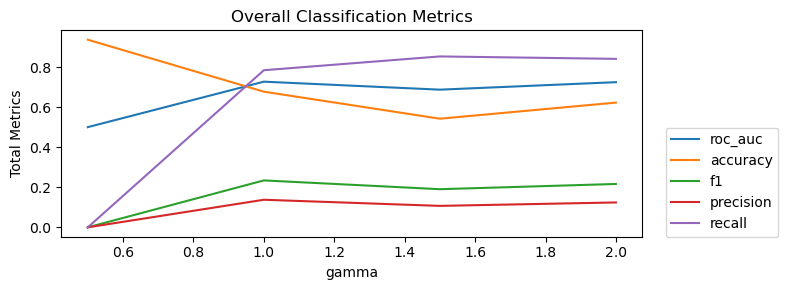

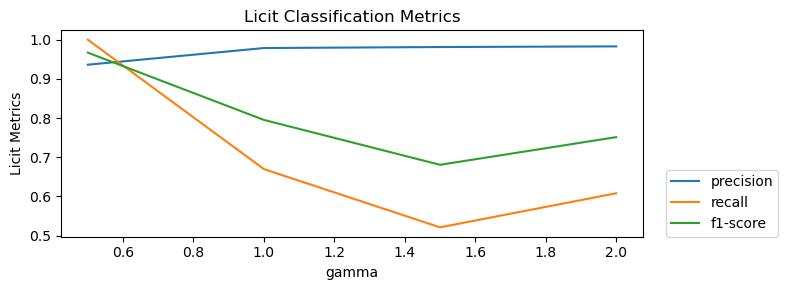

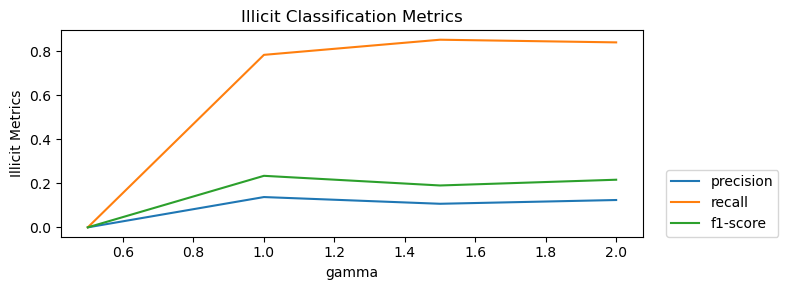

In [7]:
plot_metrics(metrics, para_list, para_change, x_log=False)

In [8]:
metrics = create_metrics()
para_change = "beta"
para_list = [0.9, 0.99, 0.999, 0.9999]

metrics = hyperparameter_loop("loss", para_change, para_list, metrics)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:04<00:44,  4.93s/it]

Avg Batch Loss: 1.229e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:09<00:39,  4.88s/it]

Avg Batch Loss: 7.781e-02, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:14<00:33,  4.73s/it]

Avg Batch Loss: 7.051e-02, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:18<00:27,  4.62s/it]

Avg Batch Loss: 6.468e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:23<00:22,  4.55s/it]

Avg Batch Loss: 5.980e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:27<00:18,  4.52s/it]

Avg Batch Loss: 5.621e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:32<00:13,  4.49s/it]

Avg Batch Loss: 5.306e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:36<00:09,  4.60s/it]

Avg Batch Loss: 4.926e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:41<00:04,  4.54s/it]

Avg Batch Loss: 4.779e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:45<00:00,  4.58s/it]

Avg Batch Loss: 4.463e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]



Test Metrics:
Accuracy: 0.931
F1: 0.210
Precision: 0.386
Recall: 0.144

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     16477
           1       0.39      0.14      0.21      1113

    accuracy                           0.93     17590
   macro avg       0.67      0.56      0.59     17590
weighted avg       0.91      0.93      0.92     17590

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5641700939440155, 'accuracy': 0.9313814667424674, 'f1': 0.20956123117223313, 'precision': 0.3864734299516908, 'recall': 0.14375561545372867, 'classification_report': {'0': {'precision': 0.9445156031672101, 'recall': 0.9845845724343023, 'f1-score': 0.9641339553680207, 'support': 16477.0}, '1': {'precision': 0.3864734299516908, 'recall': 0.14375561545372867, 'f1-score': 0.20956123117223313, 'support': 1113.0}, 'accuracy': 0.9313814667424674, 'macro avg': {'precision': 0.6654945165594505, 'recall': 0.56417

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:04<00:43,  4.89s/it]

Avg Batch Loss: 1.682e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:09<00:37,  4.69s/it]

Avg Batch Loss: 9.469e-02, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:13<00:31,  4.56s/it]

Avg Batch Loss: 8.953e-02, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:18<00:27,  4.51s/it]

Avg Batch Loss: 7.868e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:22<00:22,  4.47s/it]

Avg Batch Loss: 6.911e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:27<00:18,  4.53s/it]

Avg Batch Loss: 6.356e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:31<00:13,  4.51s/it]

Avg Batch Loss: 5.811e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:36<00:08,  4.47s/it]

Avg Batch Loss: 5.332e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:40<00:04,  4.47s/it]

Avg Batch Loss: 4.930e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:45<00:00,  4.51s/it]

Avg Batch Loss: 4.708e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]



Test Metrics:
Accuracy: 0.883
F1: 0.315
Precision: 0.247
Recall: 0.434

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94     16519
           1       0.25      0.43      0.32      1096

    accuracy                           0.88     17615
   macro avg       0.60      0.67      0.63     17615
weighted avg       0.92      0.88      0.90     17615

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6733249657660301, 'accuracy': 0.8826000567697985, 'f1': 0.3152317880794702, 'precision': 0.24740124740124741, 'recall': 0.4343065693430657, 'classification_report': {'0': {'precision': 0.9604869033203748, 'recall': 0.9123433621889945, 'f1-score': 0.9357963365414468, 'support': 16519.0}, '1': {'precision': 0.24740124740124741, 'recall': 0.4343065693430657, 'f1-score': 0.3152317880794702, 'support': 1096.0}, 'accuracy': 0.8826000567697985, 'macro avg': {'precision': 0.6039440753608111, 'recall': 0.6733249

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:04<00:42,  4.70s/it]

Avg Batch Loss: 5.559e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:09<00:36,  4.57s/it]

Avg Batch Loss: 1.002e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:13<00:31,  4.51s/it]

Avg Batch Loss: 9.673e-02, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:18<00:26,  4.48s/it]

Avg Batch Loss: 9.519e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:22<00:22,  4.44s/it]

Avg Batch Loss: 9.463e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:27<00:18,  4.59s/it]

Avg Batch Loss: 8.753e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:31<00:13,  4.53s/it]

Avg Batch Loss: 8.020e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:36<00:08,  4.49s/it]

Avg Batch Loss: 7.627e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:40<00:04,  4.47s/it]

Avg Batch Loss: 7.129e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:44<00:00,  4.50s/it]

Avg Batch Loss: 6.909e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]



Test Metrics:
Accuracy: 0.881
F1: 0.273
Precision: 0.221
Recall: 0.355

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     16538
           1       0.22      0.36      0.27      1109

    accuracy                           0.88     17647
   macro avg       0.59      0.64      0.60     17647
weighted avg       0.91      0.88      0.89     17647

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6356735494864356, 'accuracy': 0.8808296027653425, 'f1': 0.2725700449671394, 'precision': 0.22109988776655443, 'recall': 0.3552750225428314, 'classification_report': {'0': {'precision': 0.9549322407815947, 'recall': 0.91607207643004, 'f1-score': 0.935098601981298, 'support': 16538.0}, '1': {'precision': 0.22109988776655443, 'recall': 0.3552750225428314, 'f1-score': 0.2725700449671394, 'support': 1109.0}, 'accuracy': 0.8808296027653425, 'macro avg': {'precision': 0.5880160642740746, 'recall': 0.6356735494

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:04<00:44,  4.96s/it]

Avg Batch Loss: 1.373e-01, 
Epoch 2/10
Avg Batch Loss: 5.425e-02, 


Epochs:  20%|██        | 2/10 [00:13<00:57,  7.20s/it]

Epoch 3/10
Avg Batch Loss: 4.856e-02, 


Epochs:  30%|███       | 3/10 [00:19<00:45,  6.48s/it]

Epoch 4/10


Epochs:  40%|████      | 4/10 [00:24<00:35,  5.96s/it]

Avg Batch Loss: 4.812e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:29<00:27,  5.47s/it]

Avg Batch Loss: 4.428e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:33<00:20,  5.11s/it]

Avg Batch Loss: 4.039e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:38<00:14,  4.91s/it]

Avg Batch Loss: 3.749e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:42<00:09,  4.77s/it]

Avg Batch Loss: 3.473e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:47<00:04,  4.76s/it]

Avg Batch Loss: 3.115e-02, 
Epoch 10/10
Avg Batch Loss: 2.972e-02, 


Epochs: 100%|██████████| 10/10 [00:52<00:00,  5.23s/it]


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Test Metrics:
Accuracy: 0.614
F1: 0.213
Precision: 0.122
Recall: 0.839

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.60      0.74     16498
           1       0.12      0.84      0.21      1095

    accuracy                           0.61     17593
   macro avg       0.55      0.72      0.48     17593
weighted avg       0.93      0.61      0.71     17593

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.7190346304602577, 'accuracy': 0.6137668390837265, 'f1': 0.21290397312637555, 'precision': 0.12191562748739719, 'recall': 0.8392694063926941, 'classification_report': {'0': {'precision': 0.982496270512183, 'recall': 0.5987998545278216, 'f1-score': 0.7440967122359056, 'support': 16498.0}, '1': {'precision': 0.12191562748739719, 'recall': 0.8392694063926941, 'f1-score': 0.21290397312637555, 'support': 1095.0}, 'accuracy': 0.6137668390837265, 'macro avg': {'precision': 0.5522059489997901, 'recall': 0.719034

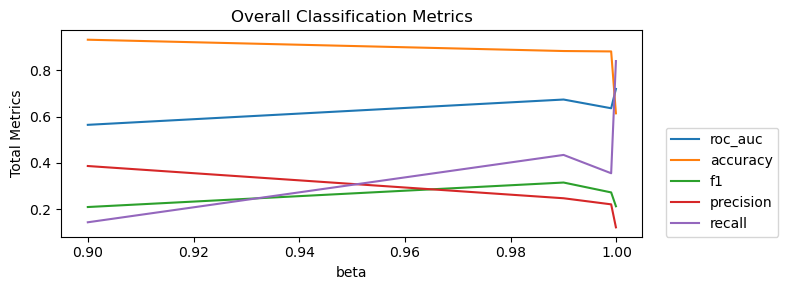

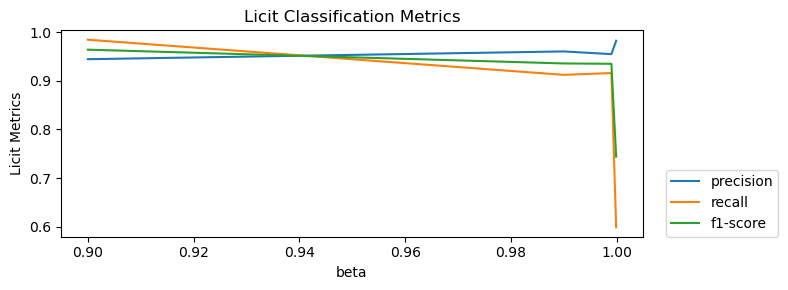

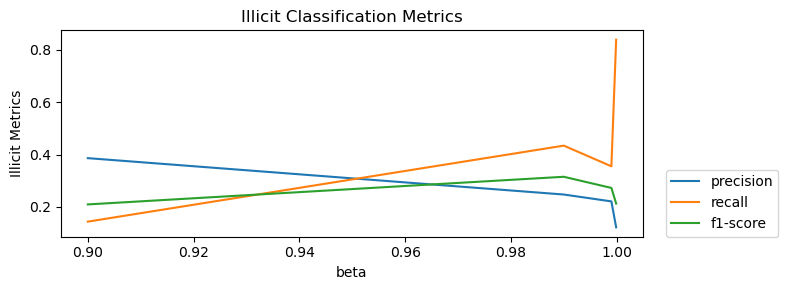

In [9]:
plot_metrics(metrics, para_list, para_change, x_log=False)